In [44]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [45]:
from os import environ
environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import keras

from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

## Load and resize the images

In [46]:
IMAGE_LIB = '../../vascus/synimages/'
MASK_LIB = '../../vascus/synmasks/'
IMG_HEIGHT, IMG_WIDTH = 64, 64
SEED=42

In [47]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.png']

x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("uint8")
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    #some normalization so values should be between 0-1
    diff = np.max(im) - np.min(im)
    #print(name + str(diff))
    if(diff!=0):
        x_data[i] = (im - np.min(im)) / diff
    else:
        x_data[i]=im/255.

y_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(MASK_LIB + name, cv2.IMREAD_UNCHANGED).astype('uint8')
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    y_data[i] = im/255.

In [48]:
x_data.shape

(328, 64, 64)

In [49]:
from sklearn.utils import shuffle

x_data, y_data = shuffle(x_data, y_data)

In [50]:
x_data.shape

(328, 64, 64)

In [51]:
x_data = x_data[:,:,:,np.newaxis]
y_data = y_data[:,:,:,np.newaxis]
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.01)

In [52]:
x_train.shape

(324, 64, 64, 1)

In [53]:
x_val.shape

(4, 64, 64, 1)

## Define and train model

In [54]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [100]:
#for 32 input

input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [55]:
#for 64 input

input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=4, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [162]:
#for 128 input

input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=64, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=48, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=128, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.1)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [203]:
#for 256 input

input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=128, kernel_size=(1,1), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=96, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=256, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [56]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 64, 64, 4)    40          input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 32, 32, 4)    0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 32, 8)    296         max_pooling2d_7[0][0]            
__________________________________________________________________________________________________
max_poolin

In [57]:
#seed is VERY important for image and mask transform simultaneously

def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            horizontal_flip=True,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=123)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            horizontal_flip=True,
            zoom_range=0.1
            ).flow(y_train, y_train, batch_size, seed=123)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

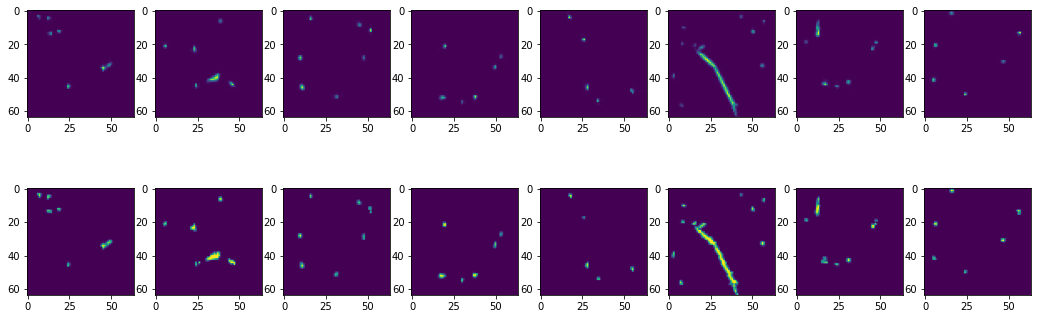

In [58]:

image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(2,8, figsize=(18,6))
for i in range(8):
    ax[0,i].imshow(image_batch[i,:,:,0])
    ax[1,i].imshow(mask_batch[i,:,:,0])
plt.show()

In [59]:
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])

In [60]:
weight_saver = ModelCheckpoint('../../models/save_syn64_best.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [61]:
callbacks = [
    keras.callbacks.ModelCheckpoint("../../models/save_syn64_st3_{epoch}.h5"),
]

In [62]:
batch_size=32
hist = model.fit_generator(my_generator(x_train, y_train, batch_size),
                           steps_per_epoch = int(x_train.shape[0]/batch_size)+1,
                           validation_data = (x_val, y_val),
                           epochs=800, 
                           callbacks = [weight_saver])
                           #callbacks = [weight_saver, annealer]) #this does not work!!
                           #callbacks = callbacks)

Epoch 1/800
11/11 [==============================] - 42s 4s/step - loss: 0.6866 - dice_coef: 0.0226 - val_loss: 0.6804 - val_dice_coef: 0.0227
Epoch 2/800
11/11 [==============================] - 1s 49ms/step - loss: 0.6710 - dice_coef: 0.0222 - val_loss: 0.6619 - val_dice_coef: 0.0224
Epoch 3/800
11/11 [==============================] - ETA: 0s - loss: 0.6454 - dice_coef: 0.022 - 1s 48ms/step - loss: 0.6431 - dice_coef: 0.0223 - val_loss: 0.6290 - val_dice_coef: 0.0216
Epoch 4/800
11/11 [==============================] - 1s 49ms/step - loss: 0.5969 - dice_coef: 0.0205 - val_loss: 0.5654 - val_dice_coef: 0.0196
Epoch 5/800
11/11 [==============================] - 1s 50ms/step - loss: 0.5095 - dice_coef: 0.0191 - val_loss: 0.4469 - val_dice_coef: 0.0158
Epoch 6/800
11/11 [==============================] - 1s 49ms/step - loss: 0.3667 - dice_coef: 0.0149 - val_loss: 0.2765 - val_dice_coef: 0.0104
Epoch 7/800
11/11 [==============================] - 1s 49ms/step - loss: 0.2228 - dice_coef:

11/11 [==============================] - 1s 49ms/step - loss: 0.0336 - dice_coef: 0.2510 - val_loss: 0.0302 - val_dice_coef: 0.2584
Epoch 58/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0334 - dice_coef: 0.2395 - val_loss: 0.0295 - val_dice_coef: 0.2676
Epoch 59/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0346 - dice_coef: 0.2576 - val_loss: 0.0288 - val_dice_coef: 0.2811
Epoch 60/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0315 - dice_coef: 0.2546 - val_loss: 0.0297 - val_dice_coef: 0.2684
Epoch 61/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0322 - dice_coef: 0.2647 - val_loss: 0.0288 - val_dice_coef: 0.2767
Epoch 62/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0313 - dice_coef: 0.2679 - val_loss: 0.0281 - val_dice_coef: 0.2939
Epoch 63/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0315 - dice_coef: 0.2794 - val_loss: 0.0280 - val_dice_coef: 0.292

11/11 [==============================] - 1s 49ms/step - loss: 0.0241 - dice_coef: 0.4312 - val_loss: 0.0185 - val_dice_coef: 0.4970
Epoch 114/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0237 - dice_coef: 0.4279 - val_loss: 0.0184 - val_dice_coef: 0.4968
Epoch 115/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0236 - dice_coef: 0.4310 - val_loss: 0.0187 - val_dice_coef: 0.4924
Epoch 116/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0240 - dice_coef: 0.4282 - val_loss: 0.0183 - val_dice_coef: 0.5001
Epoch 117/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0240 - dice_coef: 0.4361 - val_loss: 0.0184 - val_dice_coef: 0.4997
Epoch 118/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0230 - dice_coef: 0.4421 - val_loss: 0.0182 - val_dice_coef: 0.5096
Epoch 119/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0234 - dice_coef: 0.4386 - val_loss: 0.0183 - val_dice_coef:

11/11 [==============================] - 1s 48ms/step - loss: 0.0216 - dice_coef: 0.4873 - val_loss: 0.0148 - val_dice_coef: 0.5984
Epoch 170/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0199 - dice_coef: 0.4965 - val_loss: 0.0148 - val_dice_coef: 0.5968
Epoch 171/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0218 - dice_coef: 0.5000 - val_loss: 0.0147 - val_dice_coef: 0.5962
Epoch 172/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0208 - dice_coef: 0.5010 - val_loss: 0.0147 - val_dice_coef: 0.5951
Epoch 173/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0205 - dice_coef: 0.4992 - val_loss: 0.0146 - val_dice_coef: 0.6006
Epoch 174/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0212 - dice_coef: 0.4964 - val_loss: 0.0146 - val_dice_coef: 0.5990
Epoch 175/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0201 - dice_coef: 0.5051 - val_loss: 0.0145 - val_dice_coef:

11/11 [==============================] - 1s 48ms/step - loss: 0.0188 - dice_coef: 0.5263 - val_loss: 0.0127 - val_dice_coef: 0.6438
Epoch 226/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0190 - dice_coef: 0.5381 - val_loss: 0.0127 - val_dice_coef: 0.6425
Epoch 227/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0187 - dice_coef: 0.5337 - val_loss: 0.0127 - val_dice_coef: 0.6397
Epoch 228/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0188 - dice_coef: 0.5323 - val_loss: 0.0126 - val_dice_coef: 0.6458
Epoch 229/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0184 - dice_coef: 0.5373 - val_loss: 0.0127 - val_dice_coef: 0.6483
Epoch 230/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0186 - dice_coef: 0.5235 - val_loss: 0.0126 - val_dice_coef: 0.6441
Epoch 231/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0188 - dice_coef: 0.5293 - val_loss: 0.0126 - val_dice_coef:

Epoch 281/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0177 - dice_coef: 0.5463 - val_loss: 0.0115 - val_dice_coef: 0.6714
Epoch 282/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0177 - dice_coef: 0.5502 - val_loss: 0.0114 - val_dice_coef: 0.6701
Epoch 283/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0173 - dice_coef: 0.5522 - val_loss: 0.0116 - val_dice_coef: 0.6744
Epoch 284/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0176 - dice_coef: 0.5537 - val_loss: 0.0114 - val_dice_coef: 0.6702
Epoch 285/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0177 - dice_coef: 0.5564 - val_loss: 0.0115 - val_dice_coef: 0.6740
Epoch 286/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0180 - dice_coef: 0.5546 - val_loss: 0.0114 - val_dice_coef: 0.6748
Epoch 287/800
11/11 [==============================] - 1s 55ms/step - loss: 0.0177 - dice_coef: 0.5541 - val_loss: 0.0114 - 

11/11 [==============================] - 1s 50ms/step - loss: 0.0173 - dice_coef: 0.5668 - val_loss: 0.0105 - val_dice_coef: 0.6903
Epoch 338/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0173 - dice_coef: 0.5722 - val_loss: 0.0107 - val_dice_coef: 0.6913
Epoch 339/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0179 - dice_coef: 0.5608 - val_loss: 0.0104 - val_dice_coef: 0.6901
Epoch 340/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0170 - dice_coef: 0.5657 - val_loss: 0.0105 - val_dice_coef: 0.6896
Epoch 341/800
11/11 [==============================] - 1s 50ms/step - loss: 0.0174 - dice_coef: 0.5662 - val_loss: 0.0105 - val_dice_coef: 0.6952
Epoch 342/800
11/11 [==============================] - 1s 50ms/step - loss: 0.0168 - dice_coef: 0.5657 - val_loss: 0.0103 - val_dice_coef: 0.6933
Epoch 343/800
11/11 [==============================] - 1s 50ms/step - loss: 0.0172 - dice_coef: 0.5685 - val_loss: 0.0105 - val_dice_coef:

11/11 [==============================] - 1s 50ms/step - loss: 0.0176 - dice_coef: 0.5854 - val_loss: 0.0098 - val_dice_coef: 0.7050
Epoch 394/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0160 - dice_coef: 0.5755 - val_loss: 0.0100 - val_dice_coef: 0.7064
Epoch 395/800
11/11 [==============================] - 1s 50ms/step - loss: 0.0163 - dice_coef: 0.5752 - val_loss: 0.0098 - val_dice_coef: 0.7052
Epoch 396/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0167 - dice_coef: 0.5778 - val_loss: 0.0098 - val_dice_coef: 0.7087
Epoch 397/800
11/11 [==============================] - 1s 50ms/step - loss: 0.0165 - dice_coef: 0.5770 - val_loss: 0.0097 - val_dice_coef: 0.7065
Epoch 398/800
11/11 [==============================] - 1s 50ms/step - loss: 0.0166 - dice_coef: 0.5890 - val_loss: 0.0098 - val_dice_coef: 0.7087
Epoch 399/800
11/11 [==============================] - 1s 50ms/step - loss: 0.0167 - dice_coef: 0.5792 - val_loss: 0.0099 - val_dice_coef:

11/11 [==============================] - 1s 49ms/step - loss: 0.0160 - dice_coef: 0.5880 - val_loss: 0.0094 - val_dice_coef: 0.7139
Epoch 450/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0161 - dice_coef: 0.5873 - val_loss: 0.0094 - val_dice_coef: 0.7160
Epoch 451/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0166 - dice_coef: 0.5814 - val_loss: 0.0095 - val_dice_coef: 0.7126
Epoch 452/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0162 - dice_coef: 0.5775 - val_loss: 0.0096 - val_dice_coef: 0.7147
Epoch 453/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0156 - dice_coef: 0.5827 - val_loss: 0.0093 - val_dice_coef: 0.7170
Epoch 454/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0163 - dice_coef: 0.5925 - val_loss: 0.0095 - val_dice_coef: 0.7190
Epoch 455/800
11/11 [==============================] - 1s 50ms/step - loss: 0.0159 - dice_coef: 0.5829 - val_loss: 0.0095 - val_dice_coef:

11/11 [==============================] - 1s 49ms/step - loss: 0.0162 - dice_coef: 0.5930 - val_loss: 0.0091 - val_dice_coef: 0.7240
Epoch 506/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0158 - dice_coef: 0.5895 - val_loss: 0.0093 - val_dice_coef: 0.7211
Epoch 507/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0153 - dice_coef: 0.5893 - val_loss: 0.0091 - val_dice_coef: 0.7207
Epoch 508/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0158 - dice_coef: 0.5826 - val_loss: 0.0092 - val_dice_coef: 0.7230
Epoch 509/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0157 - dice_coef: 0.5923 - val_loss: 0.0091 - val_dice_coef: 0.7239
Epoch 510/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0161 - dice_coef: 0.5947 - val_loss: 0.0090 - val_dice_coef: 0.7270
Epoch 511/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0161 - dice_coef: 0.5959 - val_loss: 0.0092 - val_dice_coef:

11/11 [==============================] - 1s 49ms/step - loss: 0.0150 - dice_coef: 0.5939 - val_loss: 0.0087 - val_dice_coef: 0.7310
Epoch 562/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0156 - dice_coef: 0.5945 - val_loss: 0.0089 - val_dice_coef: 0.7257
Epoch 563/800
11/11 [==============================] - 1s 50ms/step - loss: 0.0163 - dice_coef: 0.5987 - val_loss: 0.0088 - val_dice_coef: 0.7273
Epoch 564/800
11/11 [==============================] - 1s 50ms/step - loss: 0.0155 - dice_coef: 0.5961 - val_loss: 0.0088 - val_dice_coef: 0.7305
Epoch 565/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0154 - dice_coef: 0.5899 - val_loss: 0.0087 - val_dice_coef: 0.7277
Epoch 566/800
11/11 [==============================] - 1s 50ms/step - loss: 0.0156 - dice_coef: 0.5978 - val_loss: 0.0087 - val_dice_coef: 0.7276
Epoch 567/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0156 - dice_coef: 0.6009 - val_loss: 0.0088 - val_dice_coef:

11/11 [==============================] - 1s 49ms/step - loss: 0.0158 - dice_coef: 0.5985 - val_loss: 0.0083 - val_dice_coef: 0.7342
Epoch 618/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0150 - dice_coef: 0.5964 - val_loss: 0.0082 - val_dice_coef: 0.7366
Epoch 619/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0157 - dice_coef: 0.6037 - val_loss: 0.0083 - val_dice_coef: 0.7374
Epoch 620/800
11/11 [==============================] - 1s 50ms/step - loss: 0.0150 - dice_coef: 0.6009 - val_loss: 0.0084 - val_dice_coef: 0.7314
Epoch 621/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0154 - dice_coef: 0.6020 - val_loss: 0.0083 - val_dice_coef: 0.7343
Epoch 622/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0155 - dice_coef: 0.6015 - val_loss: 0.0084 - val_dice_coef: 0.7328
Epoch 623/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0149 - dice_coef: 0.5945 - val_loss: 0.0082 - val_dice_coef:

11/11 [==============================] - 1s 49ms/step - loss: 0.0148 - dice_coef: 0.6019 - val_loss: 0.0081 - val_dice_coef: 0.7340
Epoch 674/800
11/11 [==============================] - 1s 50ms/step - loss: 0.0150 - dice_coef: 0.6059 - val_loss: 0.0080 - val_dice_coef: 0.7344
Epoch 675/800
11/11 [==============================] - 1s 50ms/step - loss: 0.0154 - dice_coef: 0.6063 - val_loss: 0.0081 - val_dice_coef: 0.7360
Epoch 676/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0145 - dice_coef: 0.6007 - val_loss: 0.0080 - val_dice_coef: 0.7354
Epoch 677/800
11/11 [==============================] - 1s 50ms/step - loss: 0.0149 - dice_coef: 0.6058 - val_loss: 0.0080 - val_dice_coef: 0.7360
Epoch 678/800
11/11 [==============================] - 1s 53ms/step - loss: 0.0151 - dice_coef: 0.6013 - val_loss: 0.0081 - val_dice_coef: 0.7337
Epoch 679/800
11/11 [==============================] - 1s 60ms/step - loss: 0.0149 - dice_coef: 0.6029 - val_loss: 0.0079 - val_dice_coef:

11/11 [==============================] - 1s 51ms/step - loss: 0.0146 - dice_coef: 0.6104 - val_loss: 0.0078 - val_dice_coef: 0.7374
Epoch 730/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0148 - dice_coef: 0.6023 - val_loss: 0.0079 - val_dice_coef: 0.7337
Epoch 731/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0146 - dice_coef: 0.6060 - val_loss: 0.0077 - val_dice_coef: 0.7398
Epoch 732/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0144 - dice_coef: 0.6124 - val_loss: 0.0078 - val_dice_coef: 0.7381
Epoch 733/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0153 - dice_coef: 0.6136 - val_loss: 0.0076 - val_dice_coef: 0.7402
Epoch 734/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0147 - dice_coef: 0.6039 - val_loss: 0.0078 - val_dice_coef: 0.7360
Epoch 735/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0148 - dice_coef: 0.6086 - val_loss: 0.0078 - val_dice_coef:

11/11 [==============================] - 1s 48ms/step - loss: 0.0152 - dice_coef: 0.6015 - val_loss: 0.0078 - val_dice_coef: 0.7349
Epoch 786/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0157 - dice_coef: 0.6025 - val_loss: 0.0076 - val_dice_coef: 0.7394
Epoch 787/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0145 - dice_coef: 0.6013 - val_loss: 0.0079 - val_dice_coef: 0.7335
Epoch 788/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0143 - dice_coef: 0.6029 - val_loss: 0.0077 - val_dice_coef: 0.7323
Epoch 789/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0147 - dice_coef: 0.6091 - val_loss: 0.0077 - val_dice_coef: 0.7377
Epoch 790/800
11/11 [==============================] - 1s 49ms/step - loss: 0.0145 - dice_coef: 0.6054 - val_loss: 0.0076 - val_dice_coef: 0.7383
Epoch 791/800
11/11 [==============================] - 1s 48ms/step - loss: 0.0149 - dice_coef: 0.6087 - val_loss: 0.0077 - val_dice_coef:

## Evaluate

In [39]:
#model.load_weights('../../models/save_lung_256_300k_50.h5')
model.load_weights('../../models/save_syn64_best.h5')

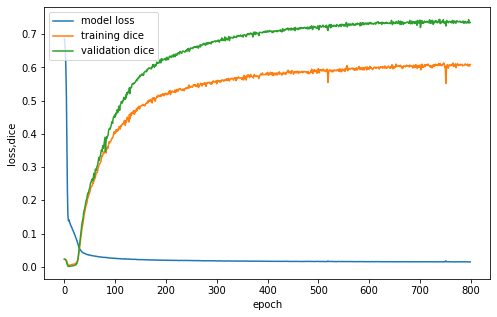

In [63]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(hist.history['loss'])
plt.plot(hist.history['dice_coef'])
plt.plot(hist.history['val_dice_coef'])
plt.title('')
plt.ylabel('loss,dice')
plt.xlabel('epoch')
plt.legend(['model loss', 'training dice','validation dice'], loc='upper left')
plt.show()

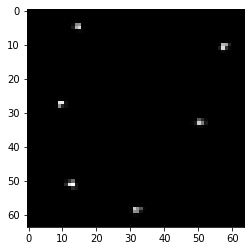

In [69]:
plt.imshow(model.predict(x_train[10].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

In [296]:
y_hat = model.predict(x_val)

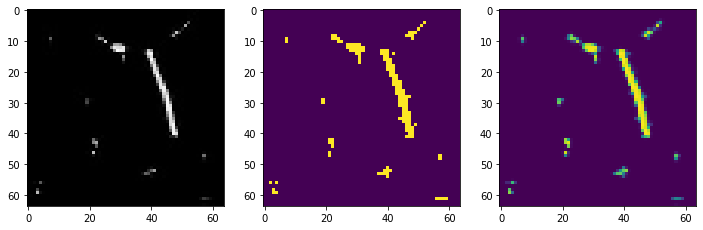

In [300]:
N=65
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[N,:,:,0], cmap='gray')
ax[1].imshow(y_val[N,:,:,0])
ax[2].imshow(y_hat[N,:,:,0])

============== TESTING ON UNKNOWN SET =================

In [70]:
IMAGE_LIB = '../../vascus/synimages_test/'
MASK_LIB = '../../vascus/synmasks_test/'
IMG_HEIGHT, IMG_WIDTH = 64, 64
SEED=42

In [71]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.png']

x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    #some normalization so values should be between 0-1
    diff = np.max(im) - np.min(im)
    if(diff!=0):
        im = (im - np.min(im)) / diff
    else:
        im=im/255.
    x_data[i] = im

y_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(MASK_LIB + name, cv2.IMREAD_UNCHANGED).astype('float32')/255.
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    y_data[i] = im

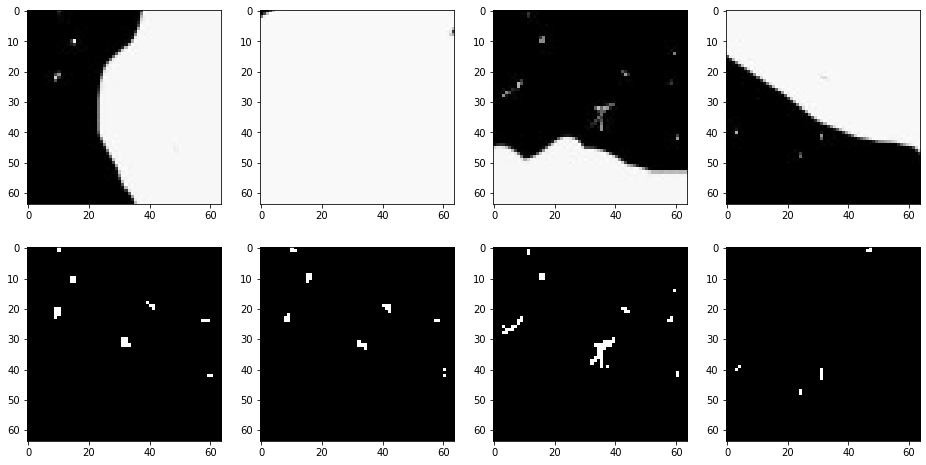

In [72]:
fig, ax = plt.subplots(2,4, figsize = (16,8))
ax[0,0].imshow(x_data[13], cmap='gray')
ax[1,0].imshow(y_data[13], cmap='gray')
ax[0,1].imshow(x_data[14], cmap='gray')
ax[1,1].imshow(y_data[14], cmap='gray')
ax[0,2].imshow(x_data[15], cmap='gray')
ax[1,2].imshow(y_data[15], cmap='gray')
ax[0,3].imshow(x_data[16], cmap='gray')
ax[1,3].imshow(y_data[16], cmap='gray')

plt.show()

In [73]:
x_test = x_data[:,:,:,np.newaxis]
y_test = y_data[:,:,:,np.newaxis]


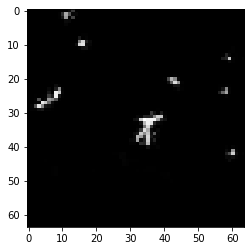

In [74]:
plt.imshow(model.predict(x_test[15].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

NOW LETS SEE IF IT WORKS ON REAL DATA

In [75]:
IMAGE_LIB = '../../lungs_ds6/norma_test/'
SRCIMG_HEIGHT, SRCIMG_WIDTH = 256, 256

In [76]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.jpg']

x_data = np.empty((len(all_images), SRCIMG_HEIGHT, SRCIMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("uint8")
    im = cv2.resize(im, dsize=(SRCIMG_HEIGHT, SRCIMG_WIDTH), interpolation=cv2.INTER_LANCZOS4)
    #some normalization so values should be between 0-1
    diff = np.max(im) - np.min(im)
    #print(diff)
    if(diff>1):
        if(diff!=0):
            im = (im - np.min(im)) / diff
        else:
            im=im/255.
            
    x_data[i] = im


In [77]:
x_data.shape

(415, 256, 256)

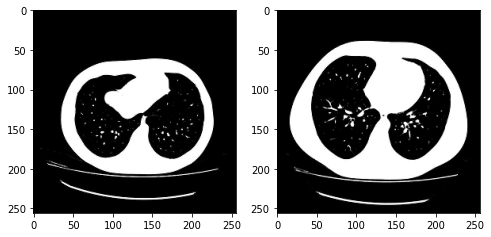

In [78]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(x_data[150], cmap='gray')
ax[1].imshow(x_data[151], cmap='gray')
plt.show()

In [79]:
#now lets make patches
from patchify import patchify, unpatchify

realimg = x_data[151]

patches = patchify(realimg, (64,64), step=64) # split image into 2*3 small 2*2 patches.

patches.shape


(4, 4, 64, 64)

In [80]:
im = patches[2,3,]

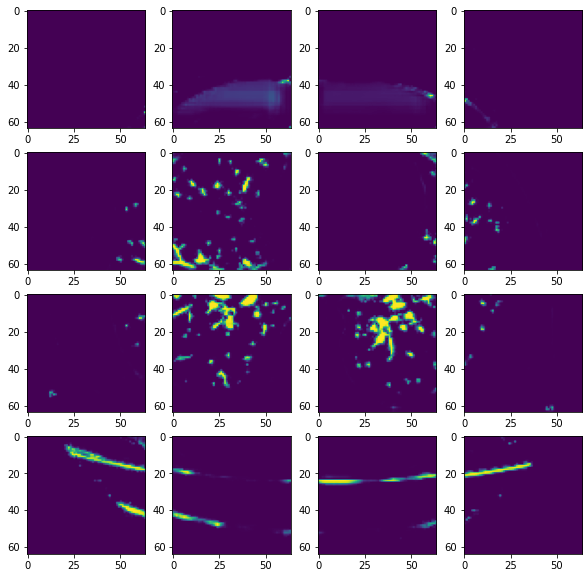

In [81]:
fix, ax = plt.subplots(4,4, figsize=(10,10))
#plt.axis('off')
#fix.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
for i in range(4):
    for j in range(4):
        im = patches[i,j,]  
        pred = model.predict(im.reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))
        ax[i,j].imshow(pred[0,:,:,0])

plt.show()



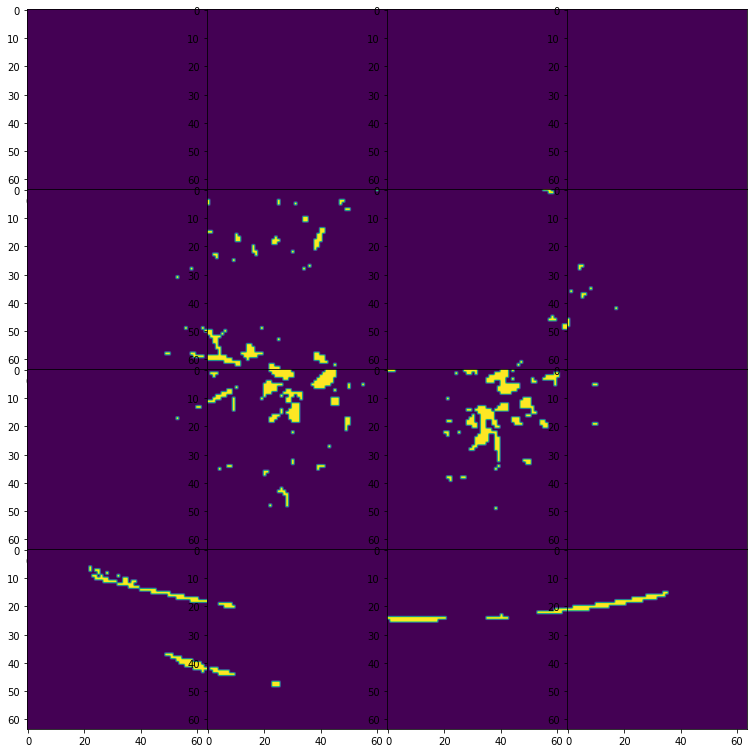

In [82]:
fix, ax = plt.subplots(4,4, figsize=(10,10))
#plt.axis('off')
fix.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
for i in range(4):
    for j in range(4):
        im = patches[i,j,]  
        pred = model.predict(im.reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))
        ret,thresh1 = cv2.threshold(pred[0,:,:,0],0.7,1.0,cv2.THRESH_BINARY)
        patches[i,j,] = thresh1
        ax[i,j].imshow(thresh1)

plt.show()


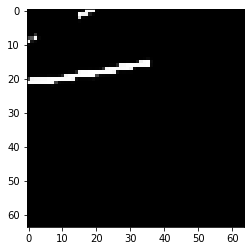

In [31]:
plt.imshow(model.predict(im.reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

In [32]:
the_mask = unpatchify(patches, realimg.shape)
the_mask.shape


(256, 256)

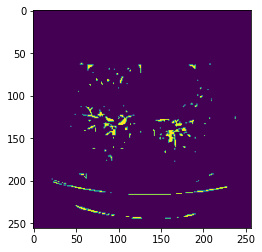

In [33]:
plt.imshow(the_mask)

=================== NOW Lets make a 3D-work ===================


In [244]:
import imageio

In [245]:
IMAGE_LIB = '../../P012/slices/'
MASK_LIB = '../../P012/vesselmasks/'
SRCIMG_HEIGHT, SRCIMG_WIDTH = 256, 256

In [246]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.png']

x_data = np.empty((len(all_images), SRCIMG_HEIGHT, SRCIMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED)
    im = cv2.resize(im, dsize=(SRCIMG_HEIGHT, SRCIMG_WIDTH), interpolation=cv2.INTER_LANCZOS4)
    alpha=3.3
    beta=-280
    im=cv2.addWeighted(im,alpha,np.zeros(im.shape, im.dtype),0,beta)
    #some normalization so values should be between 0-1
    diff = np.max(im) - np.min(im)
    if(diff!=0):
        im = (im - np.min(im)) / diff
    else:
        im=im/255.
            
    x_data[i] = im


In [193]:
x_data.shape

(328, 64, 64, 1)

In [248]:
IMG_HEIGHT = 64
IMG_WIDTH = 64

def procesImage(img):
    
    realimg = img.copy()
    
    patches = patchify(realimg, (IMG_HEIGHT,IMG_WIDTH), step=IMG_WIDTH)
    
    for i in range(4):
        for j in range(4):
            im = patches[i,j,] 
            pred = model.predict(im.reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))
            ret,thresh1 = cv2.threshold(pred[0,:,:,0],0.7,1.0,cv2.THRESH_BINARY)
            patches[i,j,] = thresh1
    
    return unpatchify(patches, realimg.shape)
    

In [249]:
masks = np.empty((x_data.shape[0], SRCIMG_HEIGHT, SRCIMG_WIDTH), dtype='float32')
N=170
#plt.imshow(x_data[N], cmap='gray')

i=-1
for img in x_data:
    i+=1
    #print(str(realimg.shape))
    #if(i!=N):
    #    continue
    #plt.imshow(img)
    themask = procesImage(img)
    #plt.imshow(themask)
    if(i>99):
        fname = ""+str(i);
    elif(i>10):
        fname = "0"+str(i);
    else:
        fname = "00"+str(i);
    #print(str(np.max(themask)))
    #plt.imshow(themask)
    themask = 255*themask
    themask = themask.astype(np.uint8)
    masks[i]=themask
    imageio.imwrite(MASK_LIB+"P012_"+fname+".png", themask)
    
print("Images saved: "+ str(i))



Images saved: 362


In [250]:
masks.shape

(363, 256, 256)

In [251]:
np.max(x_data)

1.0

In [252]:
np.max(masks)

255.0

In [253]:
np.min(masks)

0.0

In [254]:
x_data = x_data-0.8
x_data = x_data*1000
x_data = x_data.astype(np.int16)


In [255]:
np.min(x_data)

-800

In [256]:
import nibabel as nib

def rotateAndSave(arr,fname):
#we need to apply some rotations before saving
    arr = np.swapaxes(arr,0,2)
    arr = np.rot90(arr)
    arr = np.rot90(arr)
    affine = np.eye(4)
    nifti_file = nib.Nifti1Image(arr,affine)

    nib.save(nifti_file, fname)
    

In [257]:
rotateAndSave(masks,MASK_LIB +"P012.nii")

In [258]:
rotateAndSave(x_data,IMAGE_LIB +"P012.nii")

In [111]:
inputfile="../../P012/slices/P012.nii"

# set fn as your 4d nifti file
nii_original_scan = nib.load(inputfile).get_fdata()
nii_original_scan.shape



(512, 512, 363)

In [ ]:
check_orientation(ct_image, ct_arr)

================== ROC-AUC??? =================

In [246]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [235]:
y_data.shape

(31, 64, 64)

In [231]:
x_test.shape

(31, 64, 64, 1)

In [232]:
y_pred = model.predict(x_test)

In [233]:
y_true = []
y_prd = []

for img in y_data:
#  pred = model(img)  # get prediction for each pixel in the image
    y_true.append(img.flatten())  # flatten all targets
#  y_pred.append(pred.to_numpy().flatten())  # flatten all predictions
for img in y_pred:
#  pred = model(img)  # get prediction for each pixel in the image
    y_prd.append(img.flatten())  # flatten all targets
#  y_pred.append(pred.to_numpy().flatten())  # flatten all predictions

In [243]:
# concatenate all predictions and targets:
y_true = np.concatenate(y_true, axis=0)
y_prd = np.concatenate(y_prd, axis=0)
# copte the ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prd)


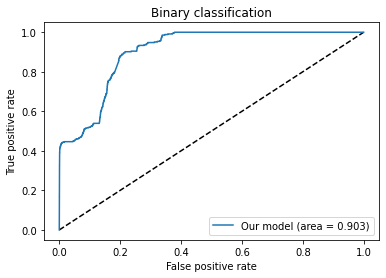

In [247]:
aucf = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Our model (area = {:.3f})'.format(aucf))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Binary classification')
plt.legend(loc='best')
plt.show()